In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
cancer = load_breast_cancer()

In [4]:
x = cancer.data
y = cancer.target

In [5]:
scaler = StandardScaler()

In [6]:
x_scaled = scaler.fit_transform(x)

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.3,random_state=42)

In [8]:
svm_linear = SVC(kernel='linear',random_state=42)
svm_linear.fit(x_train,y_train)
y_pred_linear = svm_linear.predict(x_test)
print("\n--- SVM with Linear Kernel ---")
print("Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))
print("Classification Report:\n", classification_report(y_test, y_pred_linear))


--- SVM with Linear Kernel ---
Accuracy: 0.9766081871345029
Confusion Matrix:
 [[ 61   2]
 [  2 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



In [9]:
svm_rbf = SVC(kernel='rbf',random_state=42)
svm_rbf.fit(x_train,y_train)
y_pred_rbf = svm_rbf.predict(x_test)
print("\n--- SVM with RBF Kernel ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))


--- SVM with RBF Kernel ---
Accuracy: 0.9707602339181286
Confusion Matrix:
 [[ 61   2]
 [  3 105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [10]:
param_grid = {
    'C' : [0.1,1,10,100],
    'gamma':[0.001,0.01,0.1,1],
    'kernel':['rbf']
}
grid_search = GridSearchCV(SVC(random_state=42),param_grid,cv=5,verbose=2,n_jobs=-1)
grid_search.fit(x_train,y_train)
print("\n--- Hyperparameter Tuning Results (RBF Kernel) ---")
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred_tuned = best_svm.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- Hyperparameter Tuning Results (RBF Kernel) ---
Best parameters found: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9672784810126581
Accuracy: 0.9883040935672515
Confusion Matrix:
 [[ 61   2]
 [  0 108]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.98      1.00      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



In [15]:
cv_scores = cross_val_score(best_svm,x_scaled,y,cv=10)
print(f"\n--- Cross-Validation Scores (Optimal SVM) ---")
print("Individual cross-validation accuracies:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation accuracies: {cv_scores.std():.4f}")


--- Cross-Validation Scores (Optimal SVM) ---
Individual cross-validation accuracies: [1.         0.98245614 0.96491228 0.98245614 0.98245614 0.98245614
 0.92982456 1.         1.         0.96428571]
Mean cross-validation accuracy: 0.9789
Standard deviation of cross-validation accuracies: 0.0205


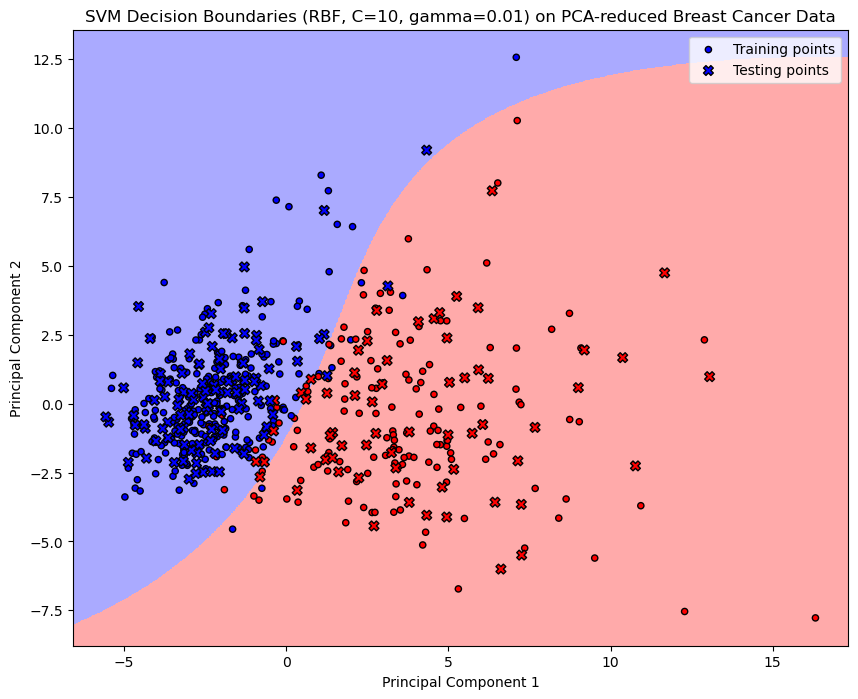

In [19]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(x_pca,y,test_size=0.3,random_state=42)

svm_pca_viz = SVC(kernel='rbf',C=best_svm.C,gamma=best_svm.gamma,random_state=42)
svm_pca_viz.fit(x_train_pca,y_train_pca)

x_min,x_max = x_pca[:,0].min()-1,x_pca[:,0].max()+1
y_min,y_max = x_pca[:,1].min()-1,x_pca[:,1].max()+1
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max,0.02))

Z = svm_pca_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF']) 
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_pca, cmap=cmap_bold,edgecolor='k', s=20, label='Training points')

plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test_pca, cmap=cmap_bold,edgecolor='k', s=50, marker='X', label='Testing points')

plt.title(f"SVM Decision Boundaries (RBF, C={best_svm.C}, gamma={best_svm.gamma}) on PCA-reduced Breast Cancer Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()